This notebook was ran and tested in Azure Machine Learning Studio, it hasn't been tested in Google Colab and it was only added to show the research and testing done on **DenseNet** for the Hotel-ID to Combat Human Trafficking 2022 - FGVC9 Kaggle competition.

# Setup

Some required installs needed to run on Azure.

In [ ]:
!pip install -Uq fastai2 --user

In [ ]:
!conda install -c fastai fastai -y

In [ ]:
!pip install fastcore fastai --upgrade

Import fastai vision module and some useful libraries.

In [ ]:
from fastai.vision.all import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load and transform data

Load images from path and store them on fns.

In [ ]:
path = "./Kaggle/hotelImages/train"
fns = get_image_files(path)

Define DataLoaders class to hold our datasets.

In [ ]:
class DataLoaders(GetAttr):
  def __init__(self, *loaders): self.loaders = loaders
  
  def __getitem__(self, i): return self.loaders[i]

  train,valid = add_props(lambda i,self: self[i])

Define our DataBlock to separate our datasets into training (80%) and valid (20%) datasets, resize our images to 128 and define some helper functions to transform our images (random flipping with reflection pad mode and random cropping of 256)

In [ ]:
hotels = DataBlock(
  blocks=(ImageBlock, CategoryBlock),
  get_items=get_image_files,
  splitter=RandomSplitter(valid_pct=0.2, seed=42),
  get_y=parent_label,
  item_tfms=Resize(128)
  ,batch_tfms=aug_transforms(do_flip=True, pad_mode="reflection", xtra_tfms=RandomResizedCrop(256))
  )

Load images to dls and show images.

In [ ]:
dls = hotels.dataloaders(path, bs=32)

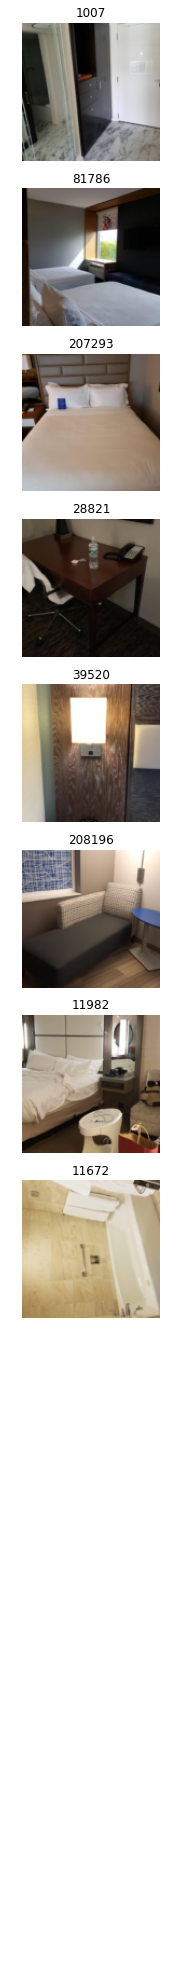

In [ ]:
dls.valid.show_batch(max_n=8, nrows=12)

# Baseline training

Train model using densenet201 with transfer learning enabled. By default is uses Adam as optimization function and no loss function. <br/>
You can find some extra documentation on cnn_learner (vision_learner) on this link: https://docs.fast.ai/vision.learner.html#vision_learner. <br/>
Train model using fine_tune function and setting 8 as number of epochs.


In [ ]:
learn = cnn_learner(dls, densenet201, metrics=[accuracy,error_rate, Dice, DiceMulti], pretrained=True)
learn.fine_tune(8)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/fastai/vision/learner.py:284: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,5.619625,4.951856,0.257815,0.742185,461.622334,0.029357,07:20


epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,4.705713,4.437434,0.288753,0.711247,467.143251,0.042217,08:50
1,4.345780,4.076294,0.334515,0.665485,462.619828,0.078803,08:51
2,3.857940,3.708258,0.380922,0.619078,477.432564,0.116917,08:53
3,3.311496,3.364046,0.427651,0.572349,487.390714,0.168583,08:54
4,2.634566,3.071232,0.462133,0.537867,483.310996,0.206870,08:52
5,2.007872,2.876112,0.498550,0.501450,485.856661,0.261262,08:55
6,1.694178,2.795362,0.516597,0.483403,488.095589,0.283307,08:53
7,1.441330,2.783641,0.518208,0.481792,488.986770,0.287723,08:54


In [ ]:
learn.save('model_densenet201_3')

Path('models/model_densenet201_3.pth')

Random **XResNet101** model training... Same settings as before.

In [ ]:
learn = vision_learner(dls, xresnet101, metrics=[accuracy,error_rate, Dice, DiceMulti], pretrained=True)
learn.fine_tune(8)


Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /home/azureuser/.cache/torch/hub/checkpoints/xrn50_940.pth


  0%|          | 0.00/244M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,6.012568,5.271616,0.227522,0.772478,461.647037,0.015980,07:58


epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,4.988719,4.702181,0.267161,0.732839,455.999935,0.024442,09:14
1,4.701740,4.507818,0.286175,0.713825,458.490994,0.046360,08:06
2,4.436517,4.276562,0.310989,0.689011,457.366537,0.061985,08:06
3,3.970320,4.091012,0.334837,0.665163,468.254518,0.091102,08:13
4,3.395384,3.888748,0.363519,0.636481,471.915599,0.114674,08:04
5,2.986152,3.787720,0.376410,0.623590,472.734978,0.130320,08:04
6,2.610360,3.726743,0.390590,0.609410,470.943169,0.142845,08:04
7,2.406681,3.707820,0.392846,0.607154,472.801576,0.142875,08:03


In [ ]:
learn.save('model_xresnet_1')

Path('models/model_xresnet_1.pth')

# Optimized Trainings

Trying out using pytorch AdamW to train DenseNet201, we set learning rate to 1e-2 and for AdamW we set weight_decay as 0.01 and eps as 1e-3. <br/>
We proceed to train using fit_one_cycle function with 8 epochs and a base learning rate of 5e-3.

In [ ]:
pytorch_adamw = partial(OptimWrapper, opt=torch.optim.AdamW)

learn = vision_learner(dls, densenet201, 
                lr=1e-2, 
                metrics=[accuracy,error_rate, Dice, DiceMulti], 
                pretrained=True,
                opt_func=partial(pytorch_adamw, weight_decay=0.01, eps=1e-3))

In [ ]:
learn.fit_one_cycle(8, 5e-3)

epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,5.903236,5.403011,0.252659,0.747341,452.580471,0.026688,08:28
1,5.004203,4.683865,0.303255,0.696745,462.948070,0.056381,07:46
2,4.545822,4.363472,0.339349,0.660651,467.607224,0.082613,07:41
3,4.192284,4.219558,0.359974,0.640026,473.845973,0.124513,07:51


In [ ]:
learn.save('model_densenet_optimized_1')

Best training without augmented dataset. Using DenseNet201 pretrained and this time we use LabelSmoothingCrossEntropy as our loss function to be able to fit some extra epochs and try out QHAdam as our optimizing function, both with base settings.

In [ ]:
learn = vision_learner(dls, densenet201,
                metrics=[accuracy,error_rate, Dice, DiceMulti], 
                pretrained=True,
                loss_func=LabelSmoothingCrossEntropy(),
                opt_func=QHAdam)

We use utility function lr_find() to visualize a graph with loss and learning rate for 1 epoch and this way we are able to get a good base learning rate to use afterwards.

SuggestedLRs(valley=0.001737800776027143)

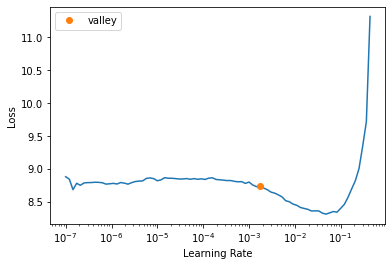

In [ ]:
# learn.lr_find()

We start training using fine_tune function for 15 epochs with a base lr of 0.002, we end up getting 59.61% accuracy with this model on our 15-Epoch which are the best results so far without using the augmented dataset.

In [ ]:
learn.fine_tune(15, 0.002)

epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,6.030476,5.259388,0.264260,0.735740,467.948575,0.032256,06:56


epoch,train_loss,valid_loss,accuracy,error_rate,dice,dice_multi,time
0,4.985419,4.823584,0.301644,0.698356,469.228295,0.050903,06:26
1,4.523584,4.503068,0.346117,0.653883,469.302329,0.093066,06:48
2,4.056201,4.210901,0.388656,0.611344,477.076819,0.138115,06:27
3,3.699290,3.939758,0.427006,0.572994,477.253405,0.186162,06:28
4,3.158849,3.694500,0.475346,0.524654,475.433682,0.240696,06:18
5,2.874310,3.556392,0.504995,0.495005,487.134335,0.286150,06:18
6,2.568599,3.458421,0.522720,0.477280,483.982335,0.317872,06:14
7,2.191221,3.359851,0.545923,0.454077,489.251792,0.345898,06:21
8,1.966095,3.327547,0.552691,0.447309,489.608363,0.355907,06:30
9,1.796441,3.252904,0.560748,0.439252,491.924202,0.356316,06:30


In [ ]:
learn.save('model_densenet_qhadam_2')

Path('models/model_densenet_qhadam_2.pth')